# ProbNum Quickstart

Follow the steps below to get started with ProbNum and learn about its basic functionality.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm 
plt.style.use('../probnum.mplstyle')

import warnings
warnings.filterwarnings('ignore')

## Linear solvers: a numerical method

ProbNum provides tools for solving numerical problems. In this tutorial, we look at the specific example of a solver for a *linear system*. The linear system is defined as $A x_* = b$, where $A\in\mathbb{R}^{d\times d}$ is a known square matrix, $b\in\mathbb{R}^d$ is a known vector, and $x_*\in\mathbb{R}^d$ is the unknown solution of the linear system. A linear solver attempts to estimate the unknown $x_*$ while being provided $A$ and $b$.

We will first see, how this is done with the `numpy.linalg.solve` solver, and later compare it to the ProbNum solver

In [2]:
import numpy as np

# Define the linear system Ax=b by defining the matrix A and vector b.
A = np.array([[7.5, 2.0, 1.0],
              [2.0, 2.0, 0.5],
              [1.0, 0.5, 5.5]])
b = np.array([1., 2., -3.])

# Solve for x using NumPy
x = np.linalg.solve(A, b)
print(x)


[-0.12366738  1.28358209 -0.63965885]


Now, we can do the exact same procedure with ProbNum, by using the `probnum.linalg.problinsolve` solver.

In [3]:
import probnum as pn

# Solve for x using ProbNum
x_rv, _, _, _ = pn.linalg.problinsolve(A, b)
print(x_rv.mean)

[-0.12366738  1.28358209 -0.63965885]


We observe, that the NumPy solver and the ProbNum solver return the exact same solution. That is encouraging! But what's the point of the ProbNum solver then? You may have noticed, that we called the return object `x_rv` instead of `x` for the ProbNum solver. This indicates that the ProbNum solver returns a *random variable* over the solution rather than a point estimator only. In this particual case, the solution `x_rv` is a [multivariate Gaussian random variable](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) of dimension $d=3$ (Gaussian distributions are also called `Normal').

In [4]:
x_rv

<Normal with shape=(3,), dtype=float64>

The mean of the normal distribution equals the best guess for the solution of the linear system, and the covariance matrix provides a measure for how certain the solver is about the solution. We can see below, that the algorithm is very certain about the solution as the covariance matrix is virtually zero. 

In [5]:
# mean defines best guess for the solution x
x_rv.mean

array([-0.12366738,  1.28358209, -0.63965885])

In [6]:
# covariance matrix provied a measure of uncertainty
x_rv.cov.todense()

array([[ 2.25574545e-32,  1.39629921e-33,  8.45001763e-33],
       [-9.53335322e-33,  4.65112082e-32,  3.57952136e-33],
       [ 1.94650580e-32,  3.57952136e-33, -1.84681917e-33]])

So what's the deal? In the above instance, we ran the ProbNum solver to full convergence which is why it returned the exact same solution as the NumPy solver. But what if we cannot afford to run the algorithm to full convergence? For example, if the linear system is large, or if an on-line algorithm needs to be fed that cannot wait until the final answer is computed? Here, the ProbNum solver provides *additional functionality* that we will have a closer look at now.

## Trading-off precision with computational cost

Instead of running all iterations of the solver, we will now attempt to run the solver for only 2 steps. This is indicated by the flag `maxiter=2`.

In [7]:
# Solve with limited computational budget
x_rv, _, _, _ = pn.linalg.problinsolve(A, b, maxiter=2)

In [8]:
# mean defines best guess for the solution x
x_rv.mean

array([-0.20110737,  1.54434494, -0.64216837])

In [9]:
# covariance matrix provies a measure of uncertainty
x_rv.cov.todense()

array([[ 2.23355410e-01, -7.52102244e-01,  7.23806730e-03],
       [-7.52102244e-01,  2.53254571e+00, -2.43726653e-02],
       [ 7.23806730e-03, -2.43726653e-02,  2.34557194e-04]])

We can already observe that the best guess for the solution (mean) has slightly changed as we did not compute the exact solution anymore. Therefore, the covariance matrix contains larger values than before, accounting for the uncertainty arising from the limited number of iterations we performed. In order to interpret the numbers in the covariance matrix properly, we will now sample from the normal distribution provided through `x_rv`. 

In [10]:
# Sample from solution distribution 
np.random.seed(1)
n_samples = 10
x_samples = x_rv.sample(n_samples)
print(x_samples)

[[-0.96878098  4.12932395 -0.66704564]
 [ 0.30598287 -0.16317454 -0.62573557]
 [-1.02571399  4.32103387 -0.66889062]
 [-0.08325372  1.14749757 -0.63834919]
 [-0.04873141  1.03125104 -0.63723048]
 [ 0.31870665 -0.20601917 -0.62532325]
 [-0.2210578   1.61152379 -0.64281488]
 [-0.74210944  3.36605529 -0.65970011]
 [-0.62685632  2.97796477 -0.65596522]
 [ 0.24114187  0.05516389 -0.62783682]]


Each sample (row) can be seen as a potential solution to the linear system. We observe that the last entry (third column) of the solution does not vary much across samples, which indicates that the solver is fairly certain about it's value, while the second entry (middle column) varies more, indicating that the solver is less certain about it's value. This is valuable information in case the solution for $x$ is used in a downstream operation.

Instead of using samples, we can also use the covariance matrix directly to get a numerical representation of the uncertainty. For this we retrieve the *marginal standard deviation* `x_rv.std` of the best guess for the solution. 

In [11]:
print(f"true solution: {x}.")
print(f"best guess for solution: {x_rv.mean}.")
print(f"marginal standard deviations: {x_rv.std}.\n")

for i in range(3):
    print(f"The marginal solution of element {i} is {x_rv.mean[i]:.2f} with a 95% credible interval pm {2 * x_rv.std[i]:.2f}.")

true solution: [-0.12366738  1.28358209 -0.63965885].
best guess for solution: [-0.20110737  1.54434494 -0.64216837].
marginal standard deviations: [0.47260492 1.59139741 0.01531526].

The marginal solution of element 0 is -0.20 with a 95% credible interval pm 0.95.
The marginal solution of element 1 is 1.54 with a 95% credible interval pm 3.18.
The marginal solution of element 2 is -0.64 with a 95% credible interval pm 0.03.


We again observe that the algorithm is most certain about the last component (indexed 2), and less certain about the others. For completeness, we attempt a visual representation of the best guess, the credible intervals as well as the first 4 samples:

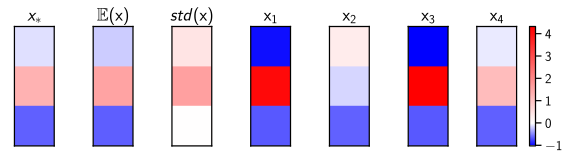

In [12]:
# collect true solution, best guess, std, and 4 samples for plotting
rvdict = {"$x_*$" : x,                             # true solution
          "$\mathbb{E}(\mathsf{x})$" : x_rv.mean,  # best guess
          "$std(\mathsf{x})$" : x_rv.std,          # marginal standard deviations
          "$\mathsf{x}_1$" : x_samples[0],         # sample No. 0
          "$\mathsf{x}_2$" : x_samples[1],         # sample No. 1
          "$\mathsf{x}_3$" : x_samples[2],         # sample No. 2
          "$\mathsf{x}_4$" : x_samples[3]          # sample No. 3
         }

# retrieve min and max values of all entries for plotting purposes
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, axes = plt.subplots(nrows=1, ncols=2 + 4 + 1, figsize=(8, 2.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    ax=axes[i].imshow(rv[:, np.newaxis], vmin=vmin, vmax=vmax, cmap='bwr', norm=norm)
    #axes[i].set_axis_off()
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].title.set_text(title)
plt.tight_layout()
plt.colorbar(ax, ax=axes[i], pad=0.2)


## Encoding Prior Knowledge

Apart from trading-off precision with computational cost, the ProbNum method has a second *additional feature* which is the ability to encode prior knowledge about the linear system at hand. It is known that encoding prior knowledge leads to faster converges to the true solution [1]. In this particular case, the prior knowledge is an approximation to the inverse of the matrix $A$, called `Ainv_approx` $\approx A^{-1}$. Such knowledge is sometimes available when consecutive, similar linear systems need to be solved. Using a related solution will help find the solution to the current linear systems faster, with less cost, and/or with a higher precision. 

Let us first define the approximate inverse of $A$:

In [13]:
# Approximate inverse of A
Ainv_approx = np.array([[ 0.2  , -0.18, -0.015],
                        [-0.18 ,  0.7 , -0.03 ],
                        [-0.015, -0.03,  0.20 ]])
print(A @ Ainv_approx)

[[1.125  0.02   0.0275]
 [0.0325 1.025  0.01  ]
 [0.0275 0.005  1.07  ]]


We can see that $A^{-1}$ and `Ainv_approx` are not completely identical, otherwise the output above would return the identity matrix $I$.

As a second piece of prior information, we consider the knowledge that $A$ and $A^{-1}$ are symmetric matrices which can be seen from the definition of $A$. Symmetric matrices are a common occurrence when solving linear systems, for example in linear regression, or Gaussian process regression.


In the case of the ProbNum solver, encoding both pieces of prior knowledge (symmetry of $A$ and $A^{-1}$ + approximate value of $A^{-1}$) is achieved by specifying a prior distribution on $A$ and $A^{-1}$:


In [14]:
from probnum import randvars, linops

# prior distribution on A
A0 = randvars.Normal(
    mean=A, cov=linops.SymmetricKronecker(10 ** -6 * linops.Identity(A.shape[0]))
)

# prior distribution on A^{-1}
Ainv0 = randvars.Normal(
    mean=Ainv_approx, cov=linops.SymmetricKronecker(0.1 * linops.Identity(A.shape[0]))
)

The random variables `A0` and `Ainv0` define symmetric [matrix-variate normal distributions](https://en.wikipedia.org/wiki/Matrix_normal_distribution) as priors [1] whose samples are symmetric matrices with mean `A` and `Ainv_approx` respectively. The covariance of `A0` is chosen very small to concentrate the prior, as $A$ is known.

We can now pass this prior information to the ProbNum solver, which is again runs with a limited budget of `maxiter=2`.

In [15]:
# Solve linear system with limited computational budget and prior knowledge
x_rv, _, _, _ = pn.linalg.problinsolve(A, b, A0=A0, Ainv0=Ainv0, maxiter=2)

In [16]:
# mean defines best guess for the solution x
x_rv.mean

array([-0.12366124,  1.28360716, -0.6396483 ])

In [17]:
# covariance matrix provies a measure of uncertainty
x_rv.cov.todense()

array([[0.00037817, 0.0015451 , 0.00064998],
       [0.0015451 , 0.00631279, 0.00265563],
       [0.00064998, 0.00265563, 0.00111716]])

We observe that the best guess for the solution (mean), even after 2 iterations only, is virtually identical to the true solution and the entries in the covariance matrix are smaller as well, indicating that the probabilistic solver is confident about the solution. 

Analogously to above, we illustrate the uncertainty about the solution by sampling from the distribution of the solution `x_rv`.

In [18]:
# Sample from solution distribution 
np.random.seed(1)
n_samples = 10
x_samples = x_rv.sample(n_samples)
print(x_samples)

[[-0.15524932  1.15454793 -0.69394021]
 [-0.10279559  1.36885782 -0.60378554]
 [-0.15759199  1.1449765  -0.69796667]
 [-0.11881182  1.30342041 -0.63131338]
 [-0.11739131  1.3092242  -0.62887187]
 [-0.10227204  1.37099691 -0.60288568]
 [-0.12448216  1.28025315 -0.64105925]
 [-0.14592228  1.19265534 -0.6779094 ]
 [-0.14117987  1.21203139 -0.66975839]
 [-0.10546366  1.35795692 -0.60837126]]


The samples, this time vary little for all three elements (columns), indicating that the solver is certain about the solution. We print the marginal standard deviations:

In [19]:
print(f"true solution: {x}.")
print(f"best guess for solution: {x_rv.mean}.")
print(f"marginal standard deviations: {x_rv.std}.\n")

for i in range(3):
    print(f"The marginal solution of element {i} is {x_rv.mean[i]:.2f} with a 95% credible interval pm {2 * x_rv.std[i]:.2f}.")

true solution: [-0.12366738  1.28358209 -0.63965885].
best guess for solution: [-0.12366124  1.28360716 -0.6396483 ].
marginal standard deviations: [0.01944665 0.07945308 0.03342387].

The marginal solution of element 0 is -0.12 with a 95% credible interval pm 0.04.
The marginal solution of element 1 is 1.28 with a 95% credible interval pm 0.16.
The marginal solution of element 2 is -0.64 with a 95% credible interval pm 0.07.


Again for completeness, we visualize the best guess, the credible intervals as well as the first 4 samples:

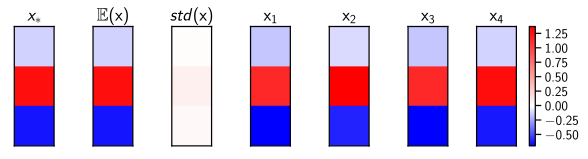

In [20]:
# collect true solution, best guess, std, and 4 samples for plotting
rvdict = {"$x_*$" : x,                             # true solution
          "$\mathbb{E}(\mathsf{x})$" : x_rv.mean,  # best guess
          "$std(\mathsf{x})$" : x_rv.std,          # marginal standard deviations
          "$\mathsf{x}_1$" : x_samples[0],         # sample No. 0
          "$\mathsf{x}_2$" : x_samples[1],         # sample No. 1
          "$\mathsf{x}_3$" : x_samples[2],         # sample No. 2
          "$\mathsf{x}_4$" : x_samples[3]          # sample No. 3
         }

# retrieve min and max values of all entries for plotting purposes
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, axes = plt.subplots(nrows=1, ncols=2 + 4 + 1, figsize=(8, 2.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    ax=axes[i].imshow(rv[:, np.newaxis], vmin=vmin, vmax=vmax, cmap='bwr', norm=norm)
    #axes[i].set_axis_off()
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].title.set_text(title)
plt.tight_layout()
plt.colorbar(ax, ax=axes[i], pad=0.2)

The ProbNum solver found a nearly perfect solution this time, with less budget (`maxiter=2`) by using the available prior information, while returning a measure of uncertainty as well. 

## References

[1] J. Wenger & P. Hennig, *Probabilistic Linear Solvers for Machine Learning*, 34th Conference on Neural Information Processing Systems (NeurIPS), 2020.